In [1]:
import sqlite3 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import requests
import numpy as np

In [2]:
con = sqlite3.connect('database.sqlite')

cur = con.cursor()

In [3]:
query = """SELECT name FROM sqlite_master
         WHERE type='table'
         ORDER BY name"""

cur.execute(query).fetchall()

[('Matches',),
 ('Teams',),
 ('Teams_in_Matches',),
 ('Unique_Teams',),
 ('sqlite_sequence',)]

In [4]:
#checking columns names
columns_team = con.execute('select * from Teams')
columns_team

In [5]:
columns_matches = con.execute('select * from Matches')
columns_matches.description

(('Match_ID', None, None, None, None, None, None),
 ('Div', None, None, None, None, None, None),
 ('Season', None, None, None, None, None, None),
 ('Date', None, None, None, None, None, None),
 ('HomeTeam', None, None, None, None, None, None),
 ('AwayTeam', None, None, None, None, None, None),
 ('FTHG', None, None, None, None, None, None),
 ('FTAG', None, None, None, None, None, None),
 ('FTR', None, None, None, None, None, None))

In [6]:
columns_matches = con.execute('select * from Teams_in_Matches')
columns_matches.description

(('Match_ID', None, None, None, None, None, None),
 ('Unique_Team_ID', None, None, None, None, None, None))

In [7]:
columns_matches = pd.DataFrame(con.execute('select * from Unique_Teams').fetchall())


In [8]:
columns_matches = con.execute('select * from sqlite_sequence')
df1 = pd.DataFrame(columns_matches)

df1

,0,1
0,Matches,46774
1,Unique_Teams,128


In [65]:
matches = cur.execute("""select Date
            from Matches 
            where Season = 2011
            AND ((Div = 'D1' OR Div='D2'))""").fetchall()

df_matches = pd.DataFrame(matches)
df_matches. columns = [i[0] for i in cur.description]


dates = df_matches['Date'].unique()

In [10]:
df_matches['Date'].unique()

array(['2010-04-04', '2009-11-01', '2009-10-04', ..., '2017-05-16',
       '2017-05-17', '2017-05-18'], dtype=object)

## 1. The name of the team

In [11]:
team_names = cur.execute(""" SELECT *
                FROM Unique_Teams
                """).fetchall()


In [12]:
team_names = pd.DataFrame(team_names)
team_names. columns = [i[0] for i in cur.description]


## 2. The total number of goals scored by the team during the 2011 season

In [13]:
home = cur.execute("""SELECT HomeTeam as team, sum(FTHG) as home
                FROM Matches
                WHERE Season = 2011
                AND ((Div = 'D1' OR Div='D2'))
                GROUP BY HomeTeam""").fetchall()


home_df = pd.DataFrame(home)
home_df.columns = [i[0] for i in cur.description]

away = cur.execute("""SELECT AwayTeam as team, sum(FTAG) as away 
                FROM Matches
                WHERE Season =2011
                AND ((Div = 'D1' OR Div='D2'))
                GROUP BY AwayTeam""").fetchall()
away_df = pd.DataFrame(away)
away_df.columns = [i[0] for i in cur.description]


In [14]:
# home_df.head()
away_df.head()

,team,away
0,Aachen,15
1,Augsburg,16
2,Bayern Munich,28
3,Bochum,18
4,Braunschweig,16


In [15]:
goals_df= pd.merge(away_df, home_df, on='team')

goals_df['total_goals'] = goals_df['home']+ goals_df['away']

goals_df.head()

,team,away,home,total_goals
0,Aachen,15,15,30
1,Augsburg,16,20,36
2,Bayern Munich,28,49,77
3,Bochum,18,23,41
4,Braunschweig,16,21,37


## 3. The total number of wins the team earned during the 2011 season

In [16]:
homewin = cur.execute("""SELECT HomeTeam as team, count(FTR) as homewin
                FROM Matches
                WHERE Season = 2011
                AND FTR='H'
                AND ((Div = 'D1' OR Div='D2'))
                GROUP BY HomeTeam""").fetchall()


homewin_df = pd.DataFrame(homewin)
homewin_df.columns = [i[0] for i in cur.description]


homewin_df.head()

,team,homewin
0,Aachen,4
1,Augsburg,6
2,Bayern Munich,14
3,Bochum,7
4,Braunschweig,6


In [28]:
homeloss = cur.execute("""SELECT HomeTeam as team, count(FTR) as homeloss 
                FROM Matches
                WHERE Season = 2011
                AND FTR='A'
                AND ((Div = 'D1' OR Div='D2'))
                GROUP BY HomeTeam""").fetchall()


homeloss_df = pd.DataFrame(homeloss)
homeloss_df.columns = [i[0] for i in cur.description]


homeloss_df.head()

,team,homeloss
0,Aachen,7
1,Augsburg,4
2,Bayern Munich,2
3,Bochum,7
4,Braunschweig,3


In [18]:
awaywin = cur.execute("""SELECT AwayTeam as team, count(FTR) as awaywin
                FROM Matches
                WHERE Season =2011
                AND FTR='A'
                AND NOT Div='E0'
                GROUP BY AwayTeam""").fetchall()

awaywin_df = pd.DataFrame(awaywin)
awaywin_df.columns = [i[0] for i in cur.description]

awaywin_df.head()

,team,awaywin
0,Aachen,2
1,Augsburg,2
2,Bayern Munich,9
3,Bochum,3
4,Braunschweig,4


In [19]:
awayloss = cur.execute("""SELECT AwayTeam as team, count(FTR) as awayloss
                FROM Matches
                WHERE Season =2011
                AND FTR='H'
                AND ((Div = 'D1' OR Div='D2'))
                GROUP BY AwayTeam""").fetchall()

awayloss_df = pd.DataFrame(awayloss)
awayloss_df.columns = [i[0] for i in cur.description]

awayloss_df.head()

,team,awayloss
0,Aachen,8
1,Augsburg,8
2,Bayern Munich,5
3,Bochum,10
4,Braunschweig,6


In [20]:
wins_df= pd.merge(awaywin_df, homewin_df, on='team')

wins_df['totalwin'] = wins_df['homewin']+ wins_df['awaywin']
wins_df.head()


,team,awaywin,homewin,totalwin
0,Aachen,2,4,6
1,Augsburg,2,6,8
2,Bayern Munich,9,14,23
3,Bochum,3,7,10
4,Braunschweig,4,6,10


In [21]:
loss_df= pd.merge(awayloss_df, homeloss_df, on='team')

loss_df['totaloss'] = loss_df['homeloss']+ loss_df['awayloss']

loss_df.head()

,team,awayloss,homeloss,totaloss
0,Aachen,8,7,15
1,Augsburg,8,4,12
2,Bayern Munich,5,2,7
3,Bochum,10,7,17
4,Braunschweig,6,3,9


In [26]:
totalwinloss = pd.merge(wins_df, loss_df, on='team', how='left')

In [27]:
totalwinloss.head()

,team,awaywin,homewin,totalwin,awayloss,homeloss,totaloss
0,Aachen,2,4,6,8.0,7.0,15.0
1,Augsburg,2,6,8,8.0,4.0,12.0
2,Bayern Munich,9,14,23,5.0,2.0,7.0
3,Bochum,3,7,10,10.0,7.0,17.0
4,Braunschweig,4,6,10,6.0,3.0,9.0


## 4. A histogram visualization of the team's wins and losses for the 2011 season (store the visualization directly)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x118b5d208>,
      dtype=object)

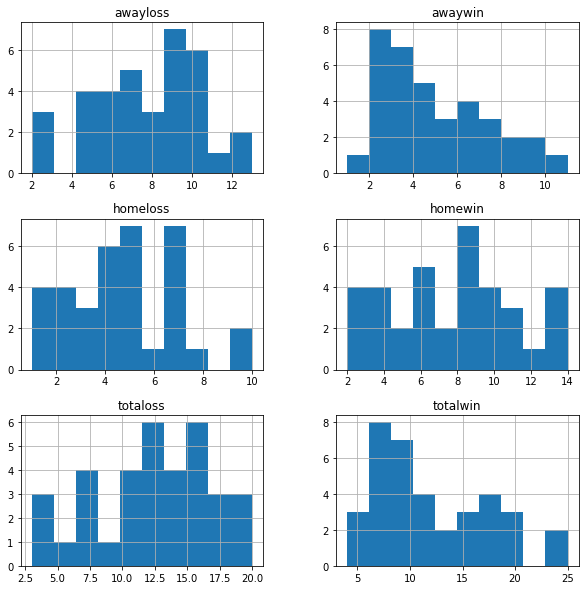

In [29]:
totalwinloss.hist(figsize=(10,10))

### API: Weather Data

In [ ]:
!pip install python-dotenv

In [61]:
# lat 52.5200, long 13.4050 for Berling
# [YYYY]-[MM]-[DD]T[HH]:[MM]:[SS][timezone]. timezone

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import os

load_dotenv()

class WeatherGetter():

    def __init__(self):
        # Let's set our secrets and keys from the .env file
        # as environment variables.
        self.BASE_URL = 'https://api.darksky.net'
        self.token = os.getenv('DARKSKY_KEY')

        if len(self.token) == 0:
            raise ValueError('Missing API key!')
    
    def getForecast(self, lat, long, time):
        url = 'https://api.darksky.net/forecast/{}/{},{},{}?exclude=currently,alerts,flags,minutely,hourly'.format(self.token,lat,long,time)
        data = requests.get(url)
        return data.json()



call = WeatherGetter()
                           
# darkweather.getForecast(52.5200,13.4050,1323626400)

first_call = call.getForecast(52.5200,13.4050,1323626400)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
dates_weather = df_matches['Date'].unique()

In [75]:
weather_json=[]

for date in dates_weather:
    weather = call.getForecast(52.5200,13.4050,date)
    weather_json.append(weather)


In [76]:
weather_json

[{'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted request'},
 {'code': 400, 'error': 'Poorly formatted requ